In [ ]:
!git version

git version 2.34.1


In [ ]:
%pip install --quiet transformers==4.36.2 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2 triton

In [ ]:
%pip install datasets huggingface_hub

In [ ]:
import torch
import matplotlib.pyplot as plt
import transformers
import torch.nn as nn
import torch.nn.functional as F
import datasets
from datasets import load_dataset
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import json
from datasets import load_dataset, load_from_disk
from huggingface_hub import notebook_login

# Обучение Ретривера

## Скачивание ЛЕНТа ру и отбор индексов (генерация датасета в другом notebook)

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/RAG_система/archive.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/RAG_система/archive.zip
  inflating: lenta-ru-news.csv       


In [ ]:
Lenta_raw = load_dataset("csv", data_files="/content/lenta-ru-news.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
Lenta_raw

DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'text', 'topic', 'tags', 'date'],
        num_rows: 800975
    })
})

In [ ]:
def lens_of_articles(article):
    if  isinstance(article, str):
        return len(article.split())
    else:
        return None


LENTA_raw_df = Lenta_raw['train'].to_pandas()

LENTA_raw_df['lens'] = LENTA_raw_df['text'].apply(lens_of_articles)

all_word_lengths = LENTA_raw_df['lens'].dropna()

quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
stats = all_word_lengths.quantile(quantiles)

print("Квантили распределения длин слов:")
print(stats)

# Пример: найти длину, в которую укладывается 95% слов
q95 = all_word_lengths.quantile(0.95)
print(f"\n95% слов имеют длину меньше или равную {q95} символам.")



Квантили распределения длин слов:
0.25    133.0
0.50    170.0
0.75    216.0
0.90    268.0
0.95    305.0
0.99    395.0
Name: lens, dtype: float64

95% слов имеют длину меньше или равную 305.0 символам.


In [ ]:
type(all_word_lengths)

pandas.core.series.Series

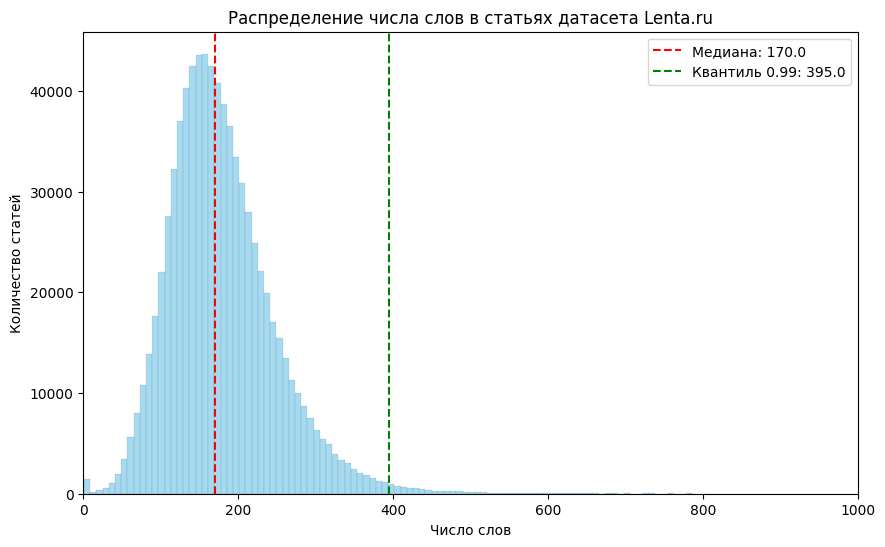

In [ ]:
#all_word_lengths = all_word_lengths[all_word_lengths > 30]
plt.figure(figsize=(10, 6))
sns.histplot(all_word_lengths, color='skyblue', bins=1010, stat="count",kde=False)
plt.title('Распределение числа слов в статьях датасета Lenta.ru')
plt.xlabel('Число слов')
plt.ylabel('Количество статей')
plt.xlim(0, 1000) # Ограничим для наглядности, так как слова длиннее 25 символов редки
plt.axvline(all_word_lengths.median(), color='red', linestyle='--', label=f'Медиана: {all_word_lengths.median()}')
plt.axvline(all_word_lengths.quantile(0.99), color='green', linestyle='--', label=f'Квантиль 0.99: {all_word_lengths.quantile(0.99)}')
plt.legend()
plt.show()

In [ ]:
LENTA_raw_df.query("lens < 30")['text'].iloc[1]

'Южная Корея и Китай намерены организова'

In [ ]:
statistic_of_lenth_lenta = [len(Lenta_raw['train'][i]['text'].split()) for i in range(len(Lenta_raw['train'])) if isinstance(Lenta_raw['train'][i]['text'], str)]

(array([ 1269.,  1939.,  2919.,  4205.,  5522.,  7055.,  8648., 10366.,
        12595., 14656., 17528., 20686., 23459., 25821., 28714., 30217.,
        31530., 32373., 32864., 32853., 32102., 31413., 29973., 29123.,
        27727., 26269., 24845., 22961., 21568., 16649., 18424., 16853.,
        15543., 14163., 12576., 11776., 10709.,  9317.,  8416.,  7683.,
         6775.,  6194.,  5548.,  4839.,  4349.,  3950.,  3593.,  3112.,
         2561.,  2466.,  2267.,  1828.,  1704.,  1495.,  1362.,  1145.,
         1080.,   920.,   838.,   739.]),
 array([ 41.        ,  46.96666667,  52.93333333,  58.9       ,
         64.86666667,  70.83333333,  76.8       ,  82.76666667,
         88.73333333,  94.7       , 100.66666667, 106.63333333,
        112.6       , 118.56666667, 124.53333333, 130.5       ,
        136.46666667, 142.43333333, 148.4       , 154.36666667,
        160.33333333, 166.3       , 172.26666667, 178.23333333,
        184.2       , 190.16666667, 196.13333333, 202.1       ,
      

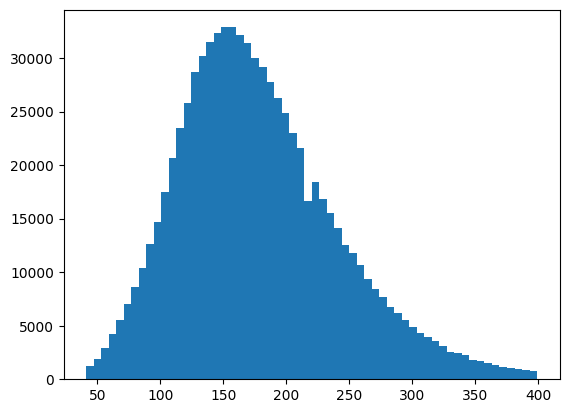

In [ ]:
plt.hist([x for x in statistic_of_lenth_lenta if (x < 400 and x > 40)], bins=60)

In [ ]:

Lenta_for_train = Lenta_raw['train'].filter(lambda example: isinstance(example['text'], str) and len(example['text'].split()) < 400 and len(example['text'].split()) > 40 and (datetime.strptime(example['date'], '%Y/%m/%d').year != 1914) )

Filter:   0%|          | 0/800975 [00:00<?, ? examples/s]

In [ ]:
Lenta_for_train

Dataset({
    features: ['url', 'title', 'text', 'topic', 'tags', 'date'],
    num_rows: 790069
})

In [ ]:
from collections import Counter
from datetime import datetime
import tqdm

years = Counter()

for d in tqdm.tqdm(Lenta_for_train['date']):
    year = datetime.strptime(d, '%Y/%m/%d').year
    years[year] += 1

years = dict(sorted(years.items()))

100%|██████████| 790069/790069 [01:26<00:00, 9112.60it/s] 


In [ ]:
years

{1914: 5,
 1999: 3009,
 2000: 15985,
 2001: 21735,
 2002: 21795,
 2003: 21044,
 2004: 22994,
 2005: 29530,
 2006: 35502,
 2007: 35449,
 2008: 49795,
 2009: 50497,
 2010: 43770,
 2011: 44541,
 2012: 45536,
 2013: 42754,
 2014: 37687,
 2015: 44330,
 2016: 62705,
 2017: 58536,
 2018: 43576,
 2019: 59299}

<StemContainer object of 3 artists>

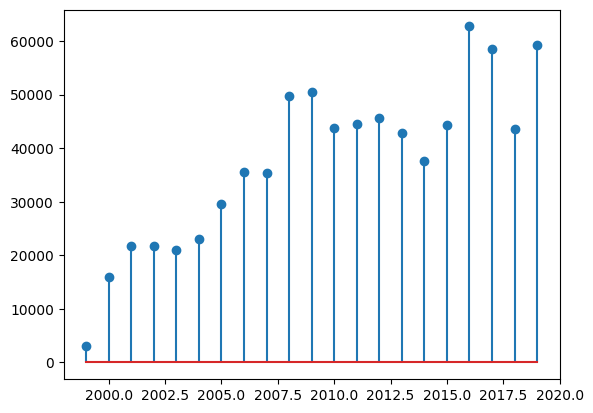

In [ ]:
plt.stem(years.keys(),years.values())

In [ ]:
N = len(Lenta_for_train)
all_indices = np.arange(N)
np.random.seed(42)
selected_indices = np.random.choice(all_indices, size=30_000, replace=False)

selected_indices = np.sort(selected_indices)  # удобно для воспроизводимости
lenta_30k = Lenta_for_train.select(selected_indices)

with open("/content/drive/MyDrive/Colab_Notebooks/RAG_система/lenta_30k_indices.json", "w") as f:
    json.dump(selected_indices.tolist(), f)

In [ ]:
lenta_30k

Dataset({
    features: ['url', 'title', 'text', 'topic', 'tags', 'date'],
    num_rows: 30000
})

In [ ]:


Lenta_for_train_50k = Lenta_for_train.shuffle(seed=42).select(range(50_000))



In [ ]:
Lenta_for_train_50k

Dataset({
    features: ['url', 'title', 'text', 'topic', 'tags', 'date'],
    num_rows: 50000
})

In [ ]:
lenta_30k.save_to_disk("/content/drive/MyDrive/Colab_Notebooks/RAG_система/Lenta_for_train_retriever_30k")

Saving the dataset (0/1 shards):   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
lenta_part1_30 = lenta_30k.select(np.arange(0, 10000))
lenta_part2_30 = lenta_30k.select(np.arange(10000, 20000))
lenta_part3_30 = lenta_30k.select(np.arange(20000, 30000))

In [ ]:
lenta_part3_30.save_to_disk("/content/drive/MyDrive/Colab_Notebooks/RAG_система/Lenta_for_train_retriever_30k_part3")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
lenta_part3_30

Dataset({
    features: ['url', 'title', 'text', 'topic', 'tags', 'date'],
    num_rows: 10000
})

## Генерация синтетического QA

Возьмём Qwen после SFT на инструкциях - Vikhrmodels/QVikhr-3-8B-Instruction

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM #Vikhrmodels/QVikhr-3-4B-Instruction "sdpa"
model_QA = AutoModelForCausalLM.from_pretrained("Vikhrmodels/QVikhr-3-4B-Instruction",device_map="auto",attn_implementation="flash_attention_2"  ,low_cpu_mem_usage=True, torch_dtype=torch.bfloat16, revision='b2a4232a1f3e5833ee0c48450374201f4a07eab7')
tokenizer_QA = AutoTokenizer.from_pretrained("Vikhrmodels/QVikhr-3-4B-Instruction", device_map="auto" , revision='b2a4232a1f3e5833ee0c48450374201f4a07eab7')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
SYSTEM_PROMPT = """Ты помощник, который формирует вопросы по статье на русском языке. Задание:
Сгенерируй РОВНО ДВА разных вопроса, на которые можно ответить,
используя ТОЛЬКО информацию из этого текста.

Требования к вопросам:
- вопросы должны быть естественными, как от читателя новостей;
- каждый вопрос должен относиться к разному аспекту статьи;
- не используй общие формулировки вроде "о чём говорится в статье";
- не добавляй информацию, которой нет в тексте.
Формат ответа — СТРОГО JSON, без комментариев и пояснений:.
{{
  "questions": [
    "первый вопрос",
    "второй вопрос"
  ]
}}
"""

### Single-inference

In [ ]:
import re
import json

def safe_parse_questions(text):
    matches = list(re.finditer(r'\{[\s\S]*?\}', text))
    if not matches:
        return None

    for m in reversed(matches):
        try:
            obj = json.loads(m.group())
        except json.JSONDecodeError:
            continue

        questions = obj.get("questions")
        if isinstance(questions, list) and len(questions) == 2:
            return questions

    return None



In [ ]:
def generate_qa(text):

    messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": f"""Текст статьи: {text}"""}
    ]

    #input_ids = tokenizer_QA.apply_chat_template(messages, truncation=True, add_generation_prompt=True, return_tensors="pt").to(model_QA.device) #tokenizer_QA(, return_tensors='pt').to(model_QA.device)

    inputs = tokenizer_QA.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_dict=True, return_tensors='pt', enable_thinking=False
    ).to(model_QA.device)



    model_QA.eval()
    with torch.inference_mode():
        output = model_QA.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer_QA.pad_token_id # Явно указываем токен падинга
        )


    decoded_output = tokenizer_QA.decode(output[0], skip_special_tokens=True)

    # The decoded output will include the instruction as well, so we need to extract only the generated part.
    # A common pattern is that the model repeats the prompt, so we can try to find the 'Ответ:' part.
    # For this specific prompt, the model's output starts after 'Ответ:'
    generated_text = decoded_output.strip()

    questions = safe_parse_questions(generated_text)
    return questions


### Batch-inference

Нужно проверить до какой длины токенов расширяются статьи из датасета

In [ ]:
Lenta_for_train_50k['text'][2]

'Житель Шетландских островов по имени Джеймс Исбистер (James Isbister) изловил мольву рекордных размеров. Об этом сообщает газета The Scotsman. Рыба длиной около 182 сантиметров весила 30 с половиной килограммов. Чтобы поместить мольву в холодильник, шотландцу пришлось сложить рыбу вдвое. Рыба будет еще какое-то время ждать засвидетельствования британским комитетом, устанавливающим рыболовные рекорды, после чего рыба будет передана музею естествознания в Лондоне. Вес мольвы на 4,5 килограмма больше веса предыдущей рекордной особи, выловленной в Великобритании 23 года назад. Стоит отметить, что это не самая большая из пойманных мольв. Абсолютный рекорд принадлежит рыбе, пойманной в Норвегии в апреле прошлого года. При той же длине, что выловленная Исбистером мольва, норвежский экземпляр весил 46,7 килограмма. Джеймс Исбистер и два его сына выловили мольву 23 февраля, когда рыбачили возле места старого кораблекрушения северней острова Макл Флугга. Этот необитаемый остров Шетландского арх

In [ ]:
lens = []
for example in tqdm(Lenta_for_train_50k['text']):
    messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": f"""Текст статьи: {example}"""}
    ]

    lens.append(len(tokenizer_QA.apply_chat_template(
                messages, tokenize=True, add_generation_prompt=True, return_dict=True, return_tensors='pt', enable_thinking=False)['input_ids'][0]))



100%|██████████| 50000/50000 [06:05<00:00, 136.91it/s]


In [ ]:
print(min(lens),max(lens),sum(lens)/len(lens))

295 1416 660.58034


In [ ]:

import re
import json


def safe_parse_questions(text):
    matches = list(re.finditer(r'\{[\s\S]*?\}', text))
    if not matches:
        return None

    for m in reversed(matches):
        try:
            obj = json.loads(m.group())
        except json.JSONDecodeError:
            continue

        questions = obj.get("questions")
        if isinstance(questions, list) and len(questions) == 2:
            return questions

    return None


def generate_qa_batch(texts, tokenizer_QA, model_QA):
    """
    texts: List[str]
    return: List[Optional[List[str]]]
    """
    #_______________________________________________________________________________
    # 1. Формируем промпты
    batch_messages = [
        [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"Текст статьи:\n{text}"}
        ]
        for text in texts
    ]

    # Настройка токенизатора
    tokenizer_QA.padding_side = "left"
    if tokenizer_QA.pad_token is None:
        tokenizer_QA.pad_token = tokenizer_QA.eos_token

    # 2. Токенизация батчем напрямую через шаблон
    # Это заменяет и цикл, и вызов tokenizer_QA(...)
    inputs = tokenizer_QA.apply_chat_template(
        batch_messages,
        add_generation_prompt=True,
        tokenize=True,            # Сразу возвращает токены
        padding=True,             # Дополняет до длиннейшего в батче
        truncation=True,          # Обрезает по max_length модели
        return_dict=True,         # Возвращает словарь с attention_mask
        return_tensors="pt",       # Возвращает тензоры PyTorch
        enable_thinking=False
    ).to(model_QA.device)
    #_______________________________________________________________________________
    # 3. Генерация
    model_QA.eval()
    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
    #with torch.amp.autocast("cuda", dtype=torch.bfloat16):
    #with torch.inference_mode():
        outputs = model_QA.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer_QA.pad_token_id,
            use_cache=True
        )

    # 4. Декодирование батчем
    decoded_outputs = tokenizer_QA.batch_decode(
        outputs,
        skip_special_tokens=True
    )

    # 5. Парсинг JSON для каждого элемента
    results = []
    for text in decoded_outputs:
        parsed = safe_parse_questions(text.strip())
        results.append(parsed)

    return results


In [ ]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [ ]:
next(model_QA.parameters()).dtype

torch.bfloat16

In [ ]:
model_QA.device

device(type='cuda', index=0)

In [ ]:
%%time
generate_qa_batch(Lenta_for_train_50k[0:205]['text'], tokenizer_QA, model_QA)

In [ ]:
def generate_batch_test_speed(texts, tokenizer_QA, model_QA):
    """
    texts: List[str]
    return: List[Optional[List[str]]]
    """
    #_______________________________________________________________________________
    # 1. Формируем промпты
    batch_messages = [
        [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"Текст статьи:\n{text}"}
        ]
        for text in texts
    ]

    # Настройка токенизатора
    tokenizer_QA.padding_side = "left"
    if tokenizer_QA.pad_token is None:
        tokenizer_QA.pad_token = tokenizer_QA.eos_token

    # 2. Токенизация батчем напрямую через шаблон
    # Это заменяет и цикл, и вызов tokenizer_QA(...)
    inputs = tokenizer_QA.apply_chat_template(
        batch_messages,
        max_length=1416,
        add_generation_prompt=True,
        tokenize=True,            # Сразу возвращает токены
        padding=True,             # Дополняет до длиннейшего в батче| БЫЛО True
        truncation=True,          # Обрезает по max_length модели
        return_dict=True,         # Возвращает словарь с attention_mask
        return_tensors="pt",       # Возвращает тензоры PyTorch
        enable_thinking=False
    ).to(model_QA.device)
    #_______________________________________________________________________________
    # 3. Генерация
    model_QA.eval()

    with torch.inference_mode(), torch.amp.autocast("cuda", dtype=torch.bfloat16):
    #with torch.amp.autocast("cuda", dtype=torch.bfloat16):
    #with torch.inference_mode():
        outputs = model_QA.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer_QA.pad_token_id,
            use_cache=True
        )

    # 4. Декодирование батчем
    decoded_outputs = tokenizer_QA.batch_decode(
        outputs,
        skip_special_tokens=True
    )
    #return decoded_outputs

In [ ]:
%%time
generate_batch_test_speed(Lenta_for_train_50k[0:208]['text'], tokenizer_QA, model_QA)

CPU times: user 51.6 s, sys: 93.5 ms, total: 51.7 s
Wall time: 51.7 s


### Генерация QA датасета

In [ ]:
part3_lenta_30k = load_from_disk('/content/drive/MyDrive/Colab_Notebooks/RAG_дублирующий/Lenta_for_train_retriever_30k_part3')

In [ ]:
from tqdm import tqdm
from datasets import Dataset

def build_qa_dataset(
    dataset,
    tokenizer_QA,
    model_QA,
    batch_size=8
):
    questions = []
    texts = []
    doc_ids = []
    # оригинальные колонки тоже возьмём
    url = []
    title = []
    topic = []
    tags = []
    date = []
    #
    count_of_None_que = 0

    for start in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[start:start + batch_size]
        batch_texts = batch["text"]

        qa_batch = generate_qa_batch(
            batch_texts,
            tokenizer_QA,
            model_QA
        )
        # нужно
        torch.cuda.empty_cache()

        for i, qa in enumerate(qa_batch):
            if qa is None:
                count_of_None_que += 1
                continue

            for q in qa:  # 2 вопроса
                questions.append(q)
                texts.append(batch_texts[i])
                doc_ids.append(start + i)
                #
                url.append(batch['url'][i])
                title.append(batch['title'][i])
                topic.append(batch['topic'][i])
                tags.append(batch['tags'][i])
                date.append(batch['date'][i])


    print(f'всего было None вопросов:{count_of_None_que}')

    return Dataset.from_dict({
        "question": questions,
        "text": texts,
        "doc_id": doc_ids,
        "url": url,
        "title":title,
        "topic":topic,
        "tags":tags,
        "date":date

    })


In [ ]:
QA_ready_part3 = build_qa_dataset(part3_lenta_30k,tokenizer_QA,model_QA,batch_size=205)

100%|██████████| 49/49 [59:16<00:00, 72.58s/it]


всего было None вопросов:48


In [ ]:
QA_ready_part3.save_to_disk("/content/drive/MyDrive/Colab_Notebooks/RAG_дублирующий/QA_Lenta_30k_part3")

Saving the dataset (0/1 shards):   0%|          | 0/19904 [00:00<?, ? examples/s]

## Залить QA датасет на HuggingFace

In [ ]:
QA_part3 = load_from_disk('/content/drive/MyDrive/Colab_Notebooks/RAG_система/QA_Lenta_30k_part3')
QA_part2 = load_from_disk('/content/drive/MyDrive/Colab_Notebooks/RAG_система/QA_Lenta_30k_part2')
QA_part1 = load_from_disk('/content/drive/MyDrive/Colab_Notebooks/RAG_система/QA_Lenta_30k_part1')

In [ ]:
QA_part1[0]

{'question': 'Какие меры были приняты для локализации очага холеры в Южно-Сахалинске?',
 'text': 'Сегодня областной центр Сахалина и Курил получил статус очага распространения холеры. Как сообщает ИТАР-ТАСС со ссылкой на пресс-центр администрации Сахалинской области, в лечебных учреждениях Южно-Сахалинска уже находятсятся 5 горожан, причем у двоих из них болезнь проходит в средне-тяжелой форме. Специалисты Госсанэпиднадзора по Сахалинской области и Хабаровской противочумной станции считают, что возможным источником заражения стала река Хомутовка в военном городке и слабосоленная красная рыба собственного приготовления, которую жители промывали в этой реке. Решением губернатора Сахалинской области Игоря Фархутдинова сегодня в Южно-Сахалинске начато развертывание специальных госпиталей и изоляторов для локализации и ликвидации очага холеры. Кроме того, на заседании санитарно-противоэпидемической комиссии было принято решение о трехкратном бактериологическом обследовании всех больных, обр

In [ ]:
from datasets import concatenate_datasets, load_dataset

# 1. Допустим, части уже загружены/созданы
# lenta_part1_30, lenta_part2_30, lenta_part3_30

# 2. Функции для изменения ID
def shift_id_part2(example):
    example["doc_id"] = example["doc_id"] + 10000
    return example

def shift_id_part3(example):
    example["doc_id"] = example["doc_id"] + 20000
    return example

# 3. Применяем изменения (первую часть оставляем как есть)
QA_part2 = QA_part2.map(shift_id_part2)
QA_part3 = QA_part3.map(shift_id_part3)

# 4. Конкатенируем (склеиваем) в один датасет
full_dataset = concatenate_datasets([QA_part1, QA_part2, QA_part3])

# 5. Заливаем на Hugging Face

Map:   0%|          | 0/19132 [00:00<?, ? examples/s]

Map:   0%|          | 0/19904 [00:00<?, ? examples/s]

In [ ]:
full_dataset

Dataset({
    features: ['question', 'text', 'doc_id', 'url', 'title', 'topic', 'tags', 'date'],
    num_rows: 58006
})

In [ ]:
notebook_login()

In [ ]:
full_dataset.push_to_hub("Daniil-Archibasov/Lenta_QA_RAG")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/59 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              :   1%|1         |  530kB / 43.8MB            

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Daniil-Archibasov/Lenta_QA_RAG/commit/3904ed9869293468863a622fedd36fdb217663a9', commit_message='Upload dataset', commit_description='', oid='3904ed9869293468863a622fedd36fdb217663a9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Daniil-Archibasov/Lenta_QA_RAG', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Daniil-Archibasov/Lenta_QA_RAG'), pr_revision=None, pr_num=None)